In [1]:
import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(1)


inputs = keras.Input(shape=(128, 128, 3), name="img")
x = layers.Conv2D(128, 3, activation="relu")(inputs)
x = layers.Conv2D(256, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(256, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(256, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(256, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(2, activation='sigmoid')(x) #softmax если более 2 классов

model = keras.Model(inputs, outputs, name="toy_resnet")

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


In [5]:
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 126, 126, 12  3584        ['img[0][0]']                    
                                8)                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 124, 124, 25  295168      ['conv2d_7[0][0]']               
                                6)                                                       

In [2]:
x_train= np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test= np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=3, min_delta=0.0002)
model.fit(x_train, y_train, batch_size=32, epochs=25, validation_split=0.2, callbacks=[callback])

Epoch 1/25
131/131 [==============================] - 4297s 33s/step - loss: 0.6480 - accuracy: 0.6747 - val_loss: 0.3335 - val_accuracy: 1.0000
Epoch 2/25
131/131 [==============================] - 4242s 32s/step - loss: 0.4946 - accuracy: 0.7184 - val_loss: 0.2310 - val_accuracy: 0.7682
Epoch 3/25
131/131 [==============================] - 4257s 33s/step - loss: 0.3511 - accuracy: 0.8449 - val_loss: 0.1269 - val_accuracy: 0.9023
Epoch 4/25
131/131 [==============================] - 4254s 32s/step - loss: 0.2979 - accuracy: 0.8876 - val_loss: 0.2380 - val_accuracy: 0.8582
Epoch 5/25
131/131 [==============================] - 4274s 33s/step - loss: 0.2287 - accuracy: 0.9166 - val_loss: 0.1038 - val_accuracy: 0.9483
Epoch 6/25
131/131 [==============================] - 4259s 33s/step - loss: 0.1879 - accuracy: 0.9298 - val_loss: 0.1699 - val_accuracy: 0.8966
Epoch 7/25
131/131 [==============================] - 4271s 33s/step - loss: 0.1876 - accuracy: 0.9291 - val_loss: 0.2171 - val_ac

In [8]:
print(model.evaluate(x_test, y_test))

20/20 [==============================] - 257s 13s/step - loss: 4.0743 - accuracy: 0.7436
[4.0742716789245605, 0.7435897588729858]


Подбор порога

In [9]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)

20/20 [==============================] - 261s 13s/step


In [10]:
from tqdm import tqdm
results = {'threshold':[], 'accuracy_score':[]}
iters = y_pred[:, 1].copy()
iters.sort()

for i in tqdm(iters):
    predict_mine = []
    for i2 in y_pred:
        if i2[1]>i:
            predict_mine.append([0.0,1.0])
        else:
            predict_mine.append([1.0, 0.0])
            
    results['threshold'].append(i)
    results['accuracy_score'].append(accuracy_score(y_test, predict_mine))

100%|██████████| 624/624 [00:01<00:00, 492.45it/s]


Text(0, 0.5, 'accuracy_score')

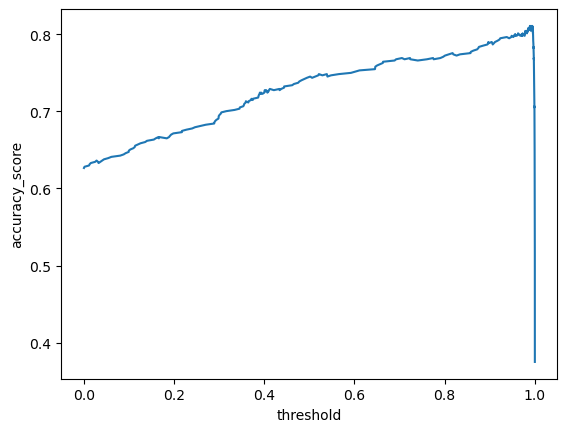

In [11]:
import matplotlib.pyplot as plt
plt.plot(results['threshold'], results['accuracy_score'])
plt.xlabel('threshold')
plt.ylabel('accuracy_score')

In [12]:
best_acc = max(results['accuracy_score'])
best_threshold = results['threshold'][results['accuracy_score'].index(best_acc)]
print(f'Лучший порог:{best_threshold} Лучшая точность:{best_acc}')

Лучший порог:0.9892129898071289 Лучшая точность:0.8108974358974359


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test[:, 1], np.where(y_pred[:, 1] > 0.5, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.87      0.37      0.52       234
         1.0       0.72      0.97      0.82       390

    accuracy                           0.74       624
   macro avg       0.79      0.67      0.67       624
weighted avg       0.78      0.74      0.71       624



In [27]:
confusion_matrix(y_test[:, 1], np.where(y_pred[:, 1] > 0.5, 1, 0))

array([[ 87, 147],
       [ 13, 377]], dtype=int64)

In [34]:
unique, counts = np.unique(y_train[:, 1], return_counts=True)
dict(zip(unique, counts))

{0.0: 1341, 1.0: 3875}

либо модель получилась переобученой либо нужен undersamling или oversampling

In [13]:
model.save('model_pneumonia_v1')

INFO:tensorflow:Assets written to: model_pneumonia_v1\assets


INFO:tensorflow:Assets written to: model_pneumonia_v1\assets


Попробую обучить на 5 эпохах

In [3]:
#перезапустил первый блок
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
131/131 [==============================] - 3775s 29s/step - loss: 0.6527 - accuracy: 0.6683 - val_loss: 0.3212 - val_accuracy: 1.0000
Epoch 2/5
131/131 [==============================] - 3735s 29s/step - loss: 0.5733 - accuracy: 0.6824 - val_loss: 0.3294 - val_accuracy: 1.0000
Epoch 3/5
131/131 [==============================] - 3733s 29s/step - loss: 0.4453 - accuracy: 0.7620 - val_loss: 0.1215 - val_accuracy: 0.9042
Epoch 4/5
131/131 [==============================] - 3738s 29s/step - loss: 0.2714 - accuracy: 0.8883 - val_loss: 0.1463 - val_accuracy: 0.9004
Epoch 5/5
131/131 [==============================] - 3735s 29s/step - loss: 0.2234 - accuracy: 0.9144 - val_loss: 0.0908 - val_accuracy: 0.9387


In [4]:
print(model.evaluate(x_test, y_test))

20/20 [==============================] - 225s 11s/step - loss: 1.2956 - accuracy: 0.6907
[1.2956082820892334, 0.6907051205635071]


In [5]:
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
131/131 [==============================] - 3725s 28s/step - loss: 0.1956 - accuracy: 0.9245 - val_loss: 0.1326 - val_accuracy: 0.9262
Epoch 2/3
131/131 [==============================] - 3726s 28s/step - loss: 0.2290 - accuracy: 0.9060 - val_loss: 0.1867 - val_accuracy: 0.8966
Epoch 3/3
131/131 [==============================] - 3760s 29s/step - loss: 0.1766 - accuracy: 0.9331 - val_loss: 0.1777 - val_accuracy: 0.9052


In [6]:
print(model.evaluate(x_test, y_test))

20/20 [==============================] - 225s 11s/step - loss: 1.1080 - accuracy: 0.7676
[1.1079622507095337, 0.7676281929016113]


In [48]:
from typing import List
def my_threshold(y_test, y_pred, metrics: List[str]):
    """
    metrics - список мметрик типа ['r2_score', 'f1_score' и.т.п]
    """

    from tqdm import tqdm
    c=0

    results = {'threshold':[]}
    for i in metrics:
        results[f'{i}'] = []
    iters = y_pred[:, 1].copy()
    iters.sort()

    for i in tqdm(iters):
        predict_mine = []
        for i2 in y_pred:
            if i2[1]>i:
                predict_mine.append([0.0, 1.0])
            else:
                predict_mine.append([1.0, 0.0])
                
        results['threshold'].append(i)
        for i in metrics:
            c+=1
            exec(f'a{c} = {i}(y_test, predict_mine)')
            exec(f'results["{i}"].append(a{c})')
    
    return results


In [ ]:
y_pred = model.predict(x_test)

100%|██████████| 624/624 [00:01<00:00, 535.77it/s]


Text(0, 0.5, 'accuracy_score')

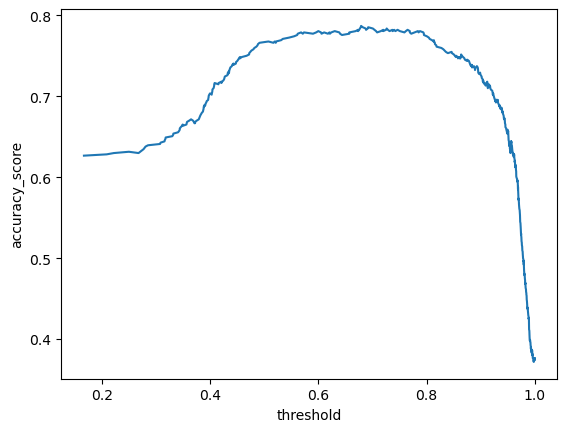

In [49]:
from sklearn.metrics import accuracy_score
res = my_threshold(y_test, y_pred, ['accuracy_score'])

import matplotlib.pyplot as plt
plt.plot(res['threshold'], res['accuracy_score'])
plt.xlabel('threshold')
plt.ylabel('accuracy_score')

In [46]:
best_acc = max(res['accuracy_score'])
best_threshold = res['threshold'][res['accuracy_score'].index(best_acc)]
print(f'Лучший порог:{best_threshold} Лучший accuracy_score:{best_acc}')

Лучший порог:0.6788942217826843 Лучший accuracy_score:0.7868589743589743


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test[:, 1], np.where(y_pred[:, 1] > 0.5, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.88      0.44      0.58       234
         1.0       0.74      0.96      0.84       390

    accuracy                           0.77       624
   macro avg       0.81      0.70      0.71       624
weighted avg       0.79      0.77      0.74       624



In [52]:
confusion_matrix(y_test[:, 1], np.where(y_pred[:, 1] > 0.5, 1, 0))

array([[102, 132],
       [ 14, 376]], dtype=int64)

In [55]:
model.save('model_pneumonia_v2')

INFO:tensorflow:Assets written to: model_pneumonia_v2\assets


INFO:tensorflow:Assets written to: model_pneumonia_v2\assets
